In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
import sys
import csv
from pprint import pprint 

plt.style.use('ggplot')

In [2]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 50

# 学習の繰り返し回数
n_epoch = 20

# 中間層の数
n_units = 4


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/misyo/data_standardized"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:3])
                target_set.append(line[4])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
N = 1200
x_train, x_test = np.split( data, [N])  
y_train, y_test = np.split( target, [N]) 
N_test = y_test.size
#print data
#print target



In [3]:
# 多層パーセプトロンモデルの設定
# 入力 2次元、出力 2次元
model = FunctionSet(l1=F.Linear(2, n_units),
                    l2=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.0, train=train)
        y = model.l2(h1)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)



In [4]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
test_loss = []
test_acc = []

l1_W = np.array('1')
l2_W = []



epoch 1
train mean loss=0.722192645073, accuracy=0.454166656981
test  mean loss=0.699064648429, accuracy=0.559883718343
epoch 2
train mean loss=0.700095050037, accuracy=0.492499999702
test  mean loss=0.678497252538, accuracy=0.653294580158
epoch 3
train mean loss=0.68079038461, accuracy=0.583333339542
test  mean loss=0.659622998201, accuracy=0.733914731085
epoch 4
train mean loss=0.663079212109, accuracy=0.655000003676
test  mean loss=0.641959850178, accuracy=0.781395347543
epoch 5
train mean loss=0.646620206535, accuracy=0.70666667074
test  mean loss=0.62503193238, accuracy=0.808527127717
epoch 6
train mean loss=0.63112132748, accuracy=0.735000001887
test  mean loss=0.60895688543, accuracy=0.827325582504
epoch 7
train mean loss=0.616147880753, accuracy=0.752500000099
test  mean loss=0.593781288742, accuracy=0.830426354741
epoch 8
train mean loss=0.602148629725, accuracy=0.761666662991
test  mean loss=0.578465824441, accuracy=0.833527126978
epoch 9
train mean loss=0.588686145842, accur

[]

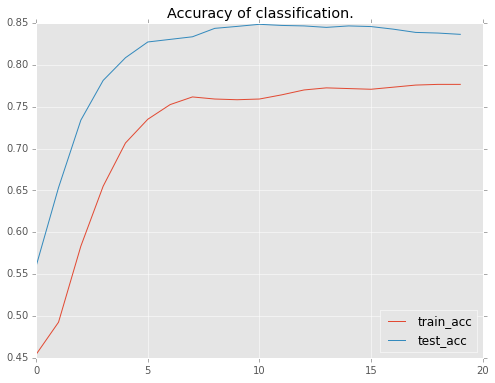

In [5]:
# Learning loop
for epoch in xrange(1, n_epoch+1):
        print 'epoch', epoch

        # training
        # N個の順番をランダムに並び替える
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        # 0〜Nまでのデータをバッチサイズごとに使って学習
        for i in xrange(0, N, batchsize):
                x_batch = x_train[perm[i:i+batchsize]]
                y_batch = y_train[perm[i:i+batchsize]]

                # 勾配を初期化
                optimizer.zero_grads()
                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch)
                # 誤差逆伝播で勾配を計算
                loss.backward()
                optimizer.update()
                
                sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # 訓練データの誤差と、正解精度を表示
        print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)
                
        train_loss.append(sum_loss / N)
        train_acc.append(sum_accuracy / N)


        # evaluation
        # テストデータで誤差と、正解精度を算出し汎化性能を確認
        sum_accuracy = 0
        sum_loss     = 0
        for i in xrange(0, N_test, batchsize):
                x_batch = x_test[i:i+batchsize]
                y_batch = y_test[i:i+batchsize]

                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch, train=False)
          


                sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # テストデータでの誤差と、正解精度を表示
        print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
        test_loss.append( sum_loss / N_test)
        test_acc.append( sum_accuracy / N_test)
        

        
        # 学習したパラメーターを保存
        #l1_W.append(model.l1.W)
        l2_W.append(model.l2.W)
        
        l1_W = np.append( l1_W, model.l1.W)
        
                      
        #pprint(vars(model.l1))
        #pprint(model.l1.W[0:2])

        # 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()


In [6]:
# 学習したパラメータを出力
print l1_W

#print l2_W
#print l3_W

['1' '0.243385180831' '0.633278667927' '0.083005733788' '-0.404107242823'
 '-0.382405668497' '-0.684236109257' '-0.367535293102' '0.366420418024'
 '0.266745388508' '0.656232178211' '0.0580128617585' '-0.427050560713'
 '-0.360159337521' '-0.662854909897' '-0.345684528351' '0.387699157'
 '0.291274547577' '0.680039644241' '0.032618522644' '-0.449179619551'
 '-0.3397962749' '-0.643511593342' '-0.326059877872' '0.406973153353'
 '0.316075742245' '0.704254984856' '0.00700184842572' '-0.471299737692'
 '-0.321260869503' '-0.625698804855' '-0.30850148201' '0.423967003822'
 '0.341537803411' '0.728143811226' '-0.0188980810344' '-0.493013232946'
 '-0.304453223944' '-0.60915851593' '-0.2931676507' '0.440147817135'
 '0.367482960224' '0.752617657185' '-0.0441642738879' '-0.515438616276'
 '-0.289246559143' '-0.59405195713' '-0.278919935226' '0.455035299063'
 '0.393154084682' '0.776309192181' '-0.0697188898921' '-0.536412596703'
 '-0.274951040745' '-0.581080555916' '-0.265155315399' '0.470089375973'
 '0

In [8]:
pprint(vars(model.l1))
pprint(vars(model.l2))

{'W': array([[ 0.69221675,  0.97149658],
       [-0.35120749, -0.74204099],
       [-0.17986614, -0.48646429],
       [-0.12201571,  0.63741136]], dtype=float32),
 'b': array([ 0.41029909,  0.29600775, -0.2109804 , -0.00146954], dtype=float32),
 'gW': array([[-0.02851585, -0.01814253],
       [ 0.06960598,  0.04130198],
       [-0.00750261, -0.00472702],
       [-0.03389475, -0.01394051]], dtype=float32),
 'gb': array([-0.01186311, -0.13013972,  0.01142588, -0.01415433], dtype=float32)}
{'W': array([[-1.0924716 ,  1.10244846,  0.2408329 , -0.24381626],
       [ 0.33471557, -0.44035417,  0.45139486,  0.75798011]], dtype=float32),
 'b': array([ 0.02525388, -0.02525389], dtype=float32),
 'gW': array([[ 0.02959166, -0.06065036, -0.00589033,  0.00470932],
       [-0.02959165,  0.06065036,  0.00589033, -0.00470932]], dtype=float32),
 'gb': array([-0.05731631,  0.05731632], dtype=float32)}
